# WebSci Coursework Q3 & Q4
Isaac Tabb

02/27/23

Use the above newsworthy scoring techniques to analyse the geo-tagged data set given above
and discuss the results.

## Q3

### Step 0: Reading in Data

#### Step 0a: Read in the geoLondonJan23.json data.

In [ ]:
# import json
import json

# create a list to hold all of the json objects
json_list = []
# open the file
with open('geoLondonJan23.json') as f:
    # iterate through each line in the file
    for line in f:
        # load an append to list
        dct = json.loads(line)
        json_list.append(dct)

print(json_list[1])

{'_id': 1617627087447154696, 'date': {'$date': '2023-01-23T20:55:26Z'}, 'screen_name': 'thedukeldn', 'qualityScore': 0.6655813953488372, 'text': 'Just getting warmed up   @ London, United Kingdom https://t.co/584EtfV0Xy', 'url': 'https://t.co/E2DsKwJRJJ', 'description': 'Luke Kenneth Andrew Lentes.\nA creative mind with multiple outlets.\nBased in London. Available worldwide.\nMaking an Elephant 🐘', 'listed_count': 1, 'user_created': {'$date': '2020-11-10T12:42:42Z'}, 'geo_enabled': True, 'favourites_count': 640, 'coordinates': [-0.1094, 51.5141], 'location': 'London, England', 'followers_count': 70, ' friends_count': 70, 'place_name': 'City of London, London', 'place_country': 'United Kingdom', 'country_code': 'GB', 'place_coordinates': [[[-0.112442, 51.5068], [-0.0733794, 51.5068], [-0.0733794, 51.522161], [-0.112442, 51.522161]]], 'hashtags': [], 'mentions': [], 'source': 'Instagram'}


#### Step 0b: Read in the HQ, LQ, and BG files.

In [ ]:
# import json
import json

# create a list to hold all of the json objects
bg_json = []
# open the file
with open('bgQuality.json') as f:
    # iterate through each line in the file
    for line in f:
        # load an append to list
        dct = json.loads(line)
        bg_json.append(dct)

# create a list to hold all of the json objects
hq_json = []
# open the file
with open('highQuality.json') as f:
    # iterate through each line in the file
    for line in f:
        # load an append to list
        dct = json.loads(line)
        hq_json.append(dct)

# create a list to hold all of the json objects
lq_json = []
# open the file
with open('lowQuality.json') as f:
    # iterate through each line in the file
    for line in f:
        # load an append to list
        dct = json.loads(line)
        lq_json.append(dct)

### Define the Newsworthiness Computation

We will define the newsworthiness scoring method which was the most effective. This was NQNST2.5, which did not use the quality score, discarded stopwords, and used a threshold of 2.5.

We need to tokenize the high and low quality models. Since we are now looking at the scoring model in terms of our geoLondonJan23 dataset, we will use the entire HQ and LQ datasets for the newsworthiness scoring this time. This is as opposed to splitting into training and validation.

Let's create our spacy tokenization method.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_tokenization(tweet):
    tokens = []
    twt = nlp(tweet)
    # applies spacy to get rid of spaces, punctuation, stopwords
    for c in twt:
        if (not c.is_stop) and (not c.is_punct) and (not c.is_space):
            # lemmatize and convert to lowercase
            tokens.append(c.lemma_.lower())

    # spacy does not recognize the '•' character which appears in some tweets
    # this removes that character
    for token in range(len(tokens)):
      if '•' in tokens[token]:
        new_token = ''
        for c in tokens[token]:
          if c != '•':
            new_token += c
   
    return tokens

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# this will give us a progress bar
from tqdm import tqdm 

for tweet in tqdm(hq_json):
    # tokenize the tweet text
    tweet['tokens'] = spacy_tokenization(tweet['text'])
    # tokenize the description as well
    tweet['tokens'].extend(spacy_tokenization(tweet['description'])) 

    # the following code gets rid of links and non-alphabet tokens
    token = 0
    while token < len(tweet['tokens']):
      if tweet['tokens'][token].isalpha() == False:
          del tweet['tokens'][token]
      else:
        token += 1

for tweet in tqdm(lq_json):
    # tokenize the tweet text
    tweet['tokens'] = spacy_tokenization(tweet['text'])
    # tokenize the description as well
    tweet['tokens'].extend(spacy_tokenization(tweet['description'])) 

    # the following code gets rid of links and non-alphabet tokens
    token = 0
    while token < len(tweet['tokens']):
      if tweet['tokens'][token].isalpha() == False:
          del tweet['tokens'][token]
      else:
        token += 1

100%|██████████| 1527/1527 [00:37<00:00, 40.70it/s]


Now we will count the term frequencies for each model.

In [ ]:
from collections import Counter
# import nltk stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english')) # this is a set of the english stopwords

# will hold dictionary of term frequencies in background collection
bg_json_tf = {}
# will hold total term frequency
bg_total_terms = 0
# iterate through background tweets
for tweet in bg_json:
  # count term frequencies in tweet
  counts = Counter(tweet['text'])
  # iterate thru term frequencies
  for key, item in counts.items():
    # if key is already in term freq dictionary, increment
    if key in bg_json_tf:
      # increment terms for current key
      bg_json_tf[key] += item
      # increment total terms
      bg_total_terms += item 
    # else, make new key
    else:
      # +0.5 is added for smoothing purposes
      bg_json_tf[key] = item + 0.5
      bg_total_terms += item + 0.5

# will hold dictionary of term frequencies in high quality collection
hq_json_tf = {}
# will hold total term frequency
hq_total_terms = 0
# iterate through high quality tweets
for tweet in hq_json:
  # count term frequencies in tweet
  counts = Counter(tweet['tokens'])
  # iterate thru term frequencies
  for key, item in counts.items():
    # due to punctuation that spacy doesn't understand
    # some stopwords remain, this causes them not to be added to the dict
    if key in stops:
      pass
    # if key is already in term freq dictionary, increment
    elif key in hq_json_tf:
      # increment terms for current key
      hq_json_tf[key] += item
      # increment total terms
      hq_total_terms += item
    # else, make new key
    else:
      # +0.5 is for smoothing
      hq_json_tf[key] = item + 0.5
      hq_total_terms += item + 0.5

# will hold dictionary of term frequencies in low quality collection
lq_json_tf = {}
# will hold total term frequency
lq_total_terms = 0
# iterate through low quality tweets
for tweet in lq_json:
  # count term frequencies in tweet
  counts = Counter(tweet['tokens'])
  # iterate thru term frequencies
  for key, item in counts.items():
    # due to punctuation that spacy doesn't understand
    # some stopwords remain, this causes them not to be added to the dict
    if key in stops:
      pass
    # if key is already in term freq dictionary, increment
    elif key in lq_json_tf:
      # increment terms for current key
      lq_json_tf[key] += item
      # increment total terms
      lq_total_terms += item
    # else, make new key
    else:
      # +0.5 is for smoothing
      lq_json_tf[key] = item + 0.5
      lq_total_terms += item + 0.5

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Next we will compute relative importances.

In [ ]:
# store the relative importances in a dictionary
hq_relimpo = {}
# iterate through the term frequency dictionary
for key, item in hq_json_tf.items():
  try:
    # this will try calculating the relative importance by looking for the key
    # in the background model
    rel_impo = (item / hq_total_terms) / (bg_json_tf[key] / bg_total_terms)
  except:
    # if a term does not exist in the background model, use add 0.5 smoothing to get rel impo
    rel_impo = (item / hq_total_terms) / (0.5 / bg_total_terms)
  
  # only save terms with importances over 2.5
  if rel_impo > 2.5:
    hq_relimpo[key] = rel_impo

lq_relimpo = {}
for key, item in lq_json_tf.items():
  try:
    # this will try calculating the relative importance by looking for the key
    # in the background model
    rel_impo = (item / lq_total_terms) / (bg_json_tf[key] / bg_total_terms)
  except:
    # if a term does not exist in the background model, use add 0.5 smoothing to get rel impo
    rel_impo = (item / lq_total_terms) / (0.5 / bg_total_terms)
  
  # only save terms with relative importance over 2.5
  if rel_impo > 2.5:
    lq_relimpo[key] = rel_impo

And finally define the newsworthiness score function.

In [ ]:
import math
# define newsworthy scoring method
def newsworthy_score(hq, lq, tokens):
  # sum of hq term relative importances
  shq = 0
  # sum of lq term relative importances
  slq = 0
  # will hold scores by token for analysis
  hq_token_scores = []
  lq_token_scores = []
  # iterate through given tokens
  for token in tokens:
    # add the token's relative importance in HQ model if exists (>2.5)
    try:
      shq += hq[token]
      # save the token score
      # this will be used to look at how definitively a term is HQ
      hq_token_scores.append(hq[token])
    except:
      pass

    # add the token's relative importance in LQ model if exists (>2.5)
    try:
      slq += lq[token]
      lq_token_scores.append(lq[token])
    except:
      pass
  
  # compute newsworthiness score and return
  news_score = math.log2((1+shq)/(1+slq))
  return {'score': news_score, 'hq_tokens': hq_token_scores, 'lq_tokens': lq_token_scores}

### (a) Apply Newsworthiness Score to geoLondon Data

First we need to tokenize the geoLondon tweets. We are going to use both the text and description. The dataset is somewhat large so this will take about 3 minutes.

In [ ]:
for tweet in tqdm(json_list):
    # tokenize the tweet text
    tweet['tokens'] = spacy_tokenization(tweet['text'])
    # tokenize the description as well
    tweet['tokens'].extend(spacy_tokenization(tweet['description'])) 

    # the following code gets rid of links and non-alphabet terms
    token = 0
    while token < len(tweet['tokens']):
      if tweet['tokens'][token].isalpha() == False:
          del tweet['tokens'][token]
      else:
        token += 1

100%|██████████| 10526/10526 [04:18<00:00, 40.79it/s]


Now we will apply the scoring method to each tweet.

In [ ]:
scores_list = []
# iterate through the list of tweets
for tweet in json_list:
  # apply the news score and save the score in the tweet dictionary
  tweet['news_score'] = newsworthy_score(hq_relimpo, lq_relimpo, tweet['tokens'])
  # also save a list of the scores for metric calculation
  scores_list.append(tweet['news_score']['score'])

Let's analyze the scores of the tweets.

In [ ]:
import statistics as st
# look at the mean and std. dev of the tweet scores
print('Avg. Score of Tweet: ' + str(round(st.mean(scores_list), 3))) # average tweet score
print('Std. Dev. of Tweet Scores: ' + str(round(st.stdev(scores_list), 3))) # std. dev. of tweet score

hq_sum = 0
# iterate through the tweets and see what percentage of tweets are being considered newsworthy
for tweet in json_list:
  if tweet['news_score']['score'] > 0:
    hq_sum += 1

print('Percent of Tweets Considered Newsworthy: ' + str(round(hq_sum/len(json_list), 3)))

Avg. Score of Tweet: 0.702
Std. Dev. of Tweet Scores: 1.748
Percent of Tweets Considered Newsworthy: 0.547


As we can see, the average tweet score is 0.702, which is above 0. A score above 0 indicates newsworthiness while a score below 0 indicates the opposite. This means that the average tweet is being considered "newsworthy". Theoretically, the average tweet should be neither newsworthy nor non-newsworthy. 

Let's look a what the top occurring terms are in the newsworthy and non-newsworthy tweets with a threshold of 0.

In [ ]:
# these dictionaries will keep track of the counts of tokens in newsworthy and
# non-newsworthy tweets
hq_counts = {}
lq_counts = {}
# iterate through the tweet list
for tweet in json_list:
  # if newsworthy, increment tokens in HQ dictionary for that tweet
  if tweet['news_score']['score'] > 0:
    for token in tweet['tokens']:
      if token in hq_counts:
        hq_counts[token] += 1
      else:
        hq_counts[token] = 1
  # if non-newsworthy, increment tokens in LQ dictionary for that tweet
  elif tweet['news_score']['score'] < 0:
    for token in tweet['tokens']:
      if token in lq_counts:
        lq_counts[token] += 1
      else:
        lq_counts[token] = 1

# define function which retrieves second element of a list
def second_elem(e):
    return e[1]

hq_ten_maxes = []
# iterate through the newsworthy dictionary
for key, item in hq_counts.items():
  # keep track of the ten max frequency terms
  if len(hq_ten_maxes) < 10:
    hq_ten_maxes.append([key, item])
    hq_ten_maxes.sort(key=second_elem, reverse=True)
  elif item > hq_ten_maxes[len(hq_ten_maxes)-1][1]:
    hq_ten_maxes[len(hq_ten_maxes)-1] = [key, item]
    hq_ten_maxes.sort(key=second_elem, reverse=True)

lq_ten_maxes = []
# iterate through the non-newsworthy dictionary
for key, item in lq_counts.items():
  # keep track of the ten max frequency terms
  if len(lq_ten_maxes) < 10:
    lq_ten_maxes.append([key, item])
    lq_ten_maxes.sort(key=second_elem, reverse=True)
  elif item > lq_ten_maxes[len(lq_ten_maxes)-1][1]:
    lq_ten_maxes[len(lq_ten_maxes)-1] = [key, item]
    lq_ten_maxes.sort(key=second_elem, reverse=True)

In [ ]:
print("Top-10 HQ Terms")
hq_ten_maxes

Top-10 HQ Terms


[['london', 4815],
 ['tweet', 2190],
 ['job', 2013],
 ['follow', 1226],
 ['need', 1142],
 ['help', 1121],
 ['account', 1119],
 ['target', 1072],
 ['geo', 1066],
 ['england', 853]]

In [ ]:
print("Top-10 LQ Terms")
lq_ten_maxes

Top-10 LQ Terms


[['london', 4404],
 ['photo', 3790],
 ['post', 3666],
 ['kingdom', 3068],
 ['united', 2679],
 ['vape', 732],
 ['base', 323],
 ['reviewer', 308],
 ['unιted', 275],
 ['artist', 264]]

By looking at the Top-10 HQ and LQ terms, we can see that a lot of the tweets in both groups are about London. The tweets in the HQ group appear to have a focus on service and goals as we see terms like "job", "need", "help", and "target". On the other hand, the tweets in LQ set seem to be more promotion based with terms like "photo", "post", "base", "reviewer", and "artist". The LQ set also includes the term "vape" a lot which is a good sign!

Our goal is to choose a threshold that makes us confident that the vast majority of the tweets we chose are truly newsworthy. Another statistic that we can look at is the average number of HQ and LQ terms in the high quality tweets. We can also look at how much weight those terms have on average. These statistics can give us a look into the ratio of HQ to LQ content in the newsworthy dataset.

In [ ]:
# will hold the number of HQ/LQ tokens in each tweet
hq_non_zeros = []
lq_non_zeros = []
# will hold the weights of the HQ/LQ tokens in tweets
hq_token_scores = []
lq_token_scores = []
# iterate through the tweets
for tweet in json_list:
  # if newsworthy (above 0)
  if tweet['news_score']['score'] > 0:
    # note how many HQ/LQ terms in the tweet
    # note the weights of the HQ/LQ terms in the tweet
    hq_non_zeros.append(len(tweet['news_score']['hq_tokens']))
    hq_token_scores.extend(tweet['news_score']['hq_tokens'])
    lq_non_zeros.append(len(tweet['news_score']['lq_tokens']))
    lq_token_scores.extend(tweet['news_score']['lq_tokens'])

print("Avg. # of HQ tokens in a HQ tweet: " + str(round(st.mean(hq_non_zeros), 2)))
print("Avg. score of HQ token in a HQ tweet: " + str(round(st.mean(hq_token_scores), 2)))
print()
print("Avg. # of LQ tokens in a HQ tweet: " + str(round(st.mean(lq_non_zeros), 2)))
print("Avg. score of LQ token in a HQ tweet: " + str(round(st.mean(lq_token_scores), 2)))

Avg. # of HQ tokens in a HQ tweet: 9.38
Avg. score of HQ token in a HQ tweet: 23.68

Avg. # of LQ tokens in a HQ tweet: 4.45
Avg. score of LQ token in a HQ tweet: 20.29


We can see here that the average HQ tweet has 9.38 HQ tokens and 4.45 LQ tokens. The average HQ token in a HQ tweet has a score of 23.68 while the average LQ token has a score of 20.29. 

With a little math we can see that the average HQ tweet is allotted an HQ sum of weights of about 222. On the other hand, the average HQ tweet is allotted an LQ sum of weights of about 90. 

That isn't terrible, it boils down to nearly a 2.5HQ to 1LQ term ratio. What if we raised the threshold so that a newsworthy tweet has to be above .702 though (the average of all tweets in the dataset)?

In [ ]:
# dictionaries to hold the term frequencies in the HQ and LQ groups
hq_counts = {}
lq_counts = {}
# iterate through the tweets
for tweet in json_list:
  # increment the counts of HQ tokens this time for tweets that are 
  # above 0.702 instead of 0
  if tweet['news_score']['score'] > 0.702:
    for token in tweet['tokens']:
      if token in hq_counts:
        hq_counts[token] += 1
      else:
        hq_counts[token] = 1
  # increment the counts of LQ tokens this time for tweets that are 
  # below 0.702 instead of 0
  elif tweet['news_score']['score'] < 0.702:
    for token in tweet['tokens']:
      if token in lq_counts:
        lq_counts[token] += 1
      else:
        lq_counts[token] = 1

hq_ten_maxes = []
# iterate through the newsworthy dictionary
for key, item in hq_counts.items():
  # keep track of the top 10 max frequency terms
  if len(hq_ten_maxes) < 10:
    hq_ten_maxes.append([key, item])
    hq_ten_maxes.sort(key=second_elem, reverse=True)
  elif item > hq_ten_maxes[len(hq_ten_maxes)-1][1]:
    hq_ten_maxes[len(hq_ten_maxes)-1] = [key, item]
    hq_ten_maxes.sort(key=second_elem, reverse=True)

lq_ten_maxes = []
# iterate through the newsworthy dictionary
for key, item in lq_counts.items():
  # keep track of the top 10 max frequency terms
  if len(lq_ten_maxes) < 10:
    lq_ten_maxes.append([key, item])
    lq_ten_maxes.sort(key=second_elem, reverse=True)
  elif item > lq_ten_maxes[len(lq_ten_maxes)-1][1]:
    lq_ten_maxes[len(lq_ten_maxes)-1] = [key, item]
    lq_ten_maxes.sort(key=second_elem, reverse=True)

In [ ]:
print("Top-10 HQ Terms")
hq_ten_maxes

Top-10 HQ Terms


[['london', 3486],
 ['tweet', 2177],
 ['job', 2008],
 ['follow', 1198],
 ['need', 1119],
 ['account', 1113],
 ['help', 1090],
 ['target', 1068],
 ['geo', 1065],
 ['england', 765]]

In [ ]:
print("Top-10 LQ Terms")
lq_ten_maxes

Top-10 LQ Terms


[['london', 5733],
 ['photo', 4397],
 ['post', 4280],
 ['kingdom', 3744],
 ['united', 3324],
 ['vape', 748],
 ['uk', 709],
 ['artist', 420],
 ['base', 400],
 ['new', 384]]

Looking at the top terms, raising the threshold doesn't change very much. There still appears to be a general focus on service and goals in the HQ tweets while the LQ tweets still have promotional terms. What about the ratio of HQ to LQ terms though?

In [ ]:
# define same lists as last time for computing evaluation metrics
hq_non_zeros = []
lq_non_zeros = []
hq_token_scores = []
lq_token_scores = []
# iterate through the tweet list
for tweet in json_list:
  # if the tweet is newsworthy (above 0.702)
  if tweet['news_score']['score'] > 0.702:
    # note the number of HQ/LQ tokens in the tweet
    # note the weights of the HQ/LQ tokens
    hq_non_zeros.append(len(tweet['news_score']['hq_tokens']))
    hq_token_scores.extend(tweet['news_score']['hq_tokens'])
    lq_non_zeros.append(len(tweet['news_score']['lq_tokens']))
    lq_token_scores.extend(tweet['news_score']['lq_tokens'])

print("Avg. # of HQ tokens in a HQ tweet (> 0.702): " + str(round(st.mean(hq_non_zeros), 2)))
print("Avg. score of HQ token in a HQ tweet (> 0.702): " + str(round(st.mean(hq_token_scores), 2)))
print()
print("Avg. # of LQ tokens in a HQ tweet (> 0.702): " + str(round(st.mean(lq_non_zeros), 2)))
print("Avg. score of LQ token in a HQ tweet (> 0.702): " + str(round(st.mean(lq_token_scores), 2)))

Avg. # of HQ tokens in a HQ tweet (> 0.702): 9.51
Avg. score of HQ token in a HQ tweet (> 0.702): 23.0

Avg. # of LQ tokens in a HQ tweet (> 0.702): 3.84
Avg. score of LQ token in a HQ tweet (> 0.702): 13.52


When we raise the threshold to the average of all tweets in the dataset, things change. The tweets that are considered newsworthy now have an average of 9.51 HQ terms compared to 3.84 LQ terms. Additionally, the average LQ term has decreased from 20.29 to 13.52. 

With a little math we see that the average sum of HQ weights for a newsworthy tweet is now around 219, which is about the same as before. The average sum of LQ weights is now about 52 though, a significant decrease. This boils down to a little more than a 4 to 1 ratio of HQ terms to LQ terms. I would consider that definitively newsworthy.

But how many of the tweets actually exceed this threshold?

In [ ]:
count = 0
for tweet in json_list:
  if tweet['news_score']['score'] > 0.702:
    count +=1

print("Number of newsworthy tweets: " + str(count))
print("As a percentage of all tweets = " + str(round(count/len(json_list), 2)))

Number of newsworthy tweets: 4094
As a percentage of all tweets = 0.39


Having 39.0% of the tweets be considered newsworthy is a pretty good proportion. It is not so many that we will likely have a lot of non-newsworthy tweets sneak in. It is also not too restrictive that we will miss a lot of newsworthy tweets.

Let's look at some random tweets that are considered newsworthy.

In [ ]:
import random
# set a random seed
random.seed('websci')

count = 0
# until there are 4 count of tweets printed
while count < 4:
  # pick a random tweet index
  rand = random.randint(0,len(json_list)-1)
  # if the tweet is newsworthy print it
  if json_list[rand]['news_score']['score'] > 0.702:
    print(json_list[rand]['screen_name'])
    print(json_list[rand]['text'])
    print()
    count += 1

tmj_CAM_mgmt
Click the link in our bio to see currently open #Consulting jobs like "Director - Authentication, Authorisation and Fraud (AA&amp;F) Subject Matter Expert (SME), Advisors Client Services" at Mastercard in #London, England.

simon_carne
Teletubbies meet Barbara Hepworth @ Oxford Street - Central London https://t.co/AjNaSsKcHq

Harry_George23
Mum’s 50th️ @ George Street https://t.co/QAgMYFcovm

tmj_lon_jobs
If you're looking for work in England, check out this #Retail job via the link in our bio: Shift Supervisor - Store# 12101, COVENT GDN WC2-RUSSE at Starbucks



Looking at the four tweets above, it looks like the tweets that are being considered newsworthy are in fact about job openings and current events! They also give details into the places that the events are occurring (i.e. street names).

Let's also checkout some random non-newsworthy tweets.

In [ ]:
import random
random.seed('websci')

# do the same as for the newsworthy tweets
# choose four random non-newsworthy tweets to print
count = 0
while count < 4:
  rand = random.randint(0,len(json_list)-1)
  if json_list[rand]['news_score']['score'] < 0.702:
    print(json_list[rand]['screen_name'])
    print(json_list[rand]['text'])
    print()
    count += 1

WeAreNook
Kin collection has (finally)landed! 

Shop the range here, or via our website at https://t.co/lUBTIweRCK @ London, United Kingdom https://t.co/UMvr41mtia

theotherjulio
Just posted a photo @ London, United Kingdom https://t.co/vyEWnqlG2W

derinmama
Just posted a photo @ London, United Kingdom https://t.co/2biZkuzPEs

CLAUDIM4R
Hello 2023 !! 
.
#newyear #2023 #hennassy #Fckery  #happynewyear #parterincrime #mayhem #claudimar @ London, United Kingdom https://t.co/1A1L4Taq4j



As we can see here, the random tweets from the LQ dataset also make sense. The first is a promotion for a product. The second and third are instagram posts and the fourth contains inappropriate hashtags.

### (b) Provide statistics of the data

Now that we have found a threshold, lets look at some statistics. Firstly, let's look at some general statistics for the newsworthy vs. non-newsworthy groups.

In [ ]:
# count of newsworthy tweets
count_news = 0
# count of non-newsworthy tweets
count_not = 0
# iterate through the tweets
for tweet in json_list:
  # if newsworthy, increment count
  if tweet['news_score']['score'] > 0.702:
    count_news +=1
  # if not, increment count
  else:
    count_not += 1

print("Number of newsworthy tweets: " + str(count_news))
print("Number of non-newsworthy tweets: " + str(count_not))

Number of newsworthy tweets: 4094
Number of non-newsworthy tweets: 6432


As we can see, just under 40% of the tweets are newsworthy while just over 60% are not.

We can also look at the average scores of newsworthy and non-newsworthy tweets.

In [ ]:
# list of scores for news tweets
scores_news = []
# list of scores for non-news tweets
scores_not = []
# iterate through the tweet list
for tweet in json_list:
  # append newsworthy scores to list they apply to
  if tweet['news_score']['score'] > 0.702:
    scores_news.append(tweet['news_score']['score'])
  else:
    scores_not.append(tweet['news_score']['score'])

print("Avg. score of newsworthy tweet: " + str(round(st.mean(scores_news), 2)))
print("Avg. score of non-newsworthy tweet: " + str(round(st.mean(scores_not), 2)))

Avg. score of newsworthy tweet: 2.54
Avg. score of non-newsworthy tweet: -0.47


This is good to see, the average non-newsworthy tweet has a score of -0.47 which is below 0. More importantly though, the average newsworthy tweet has a score of 2.54, which is a pretty strong newsworthiness score!

Let's look at how the data is distributed. For instance, how many tweets have scores above 1.0? 2.0? Etc.?


In [ ]:
# following are the counts of newsworthy tweets above certain thresholds
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0
count7 = 0
# iterate through the tweet list, keeping track of the counts for tweets
# with scores above each threshold from 1.0 to 7.0
for tweet in json_list:
  if tweet['news_score']['score'] > 1.0:
    count1 +=1
  if tweet['news_score']['score'] > 2.0:
    count2 +=1
  if tweet['news_score']['score'] > 3.0:
    count3 +=1
  if tweet['news_score']['score'] > 4.0:
    count4 +=1
  if tweet['news_score']['score'] > 5.0:
    count5 +=1
  if tweet['news_score']['score'] > 6.0:
    count6 +=1
  if tweet['news_score']['score'] > 7.0:
    count7 +=1

print("Number of newsworthy tweets w/ score > 1.0: " + str(count1))  
print("Number of newsworthy tweets w/ score > 2.0: " + str(count2))  
print("Number of newsworthy tweets w/ score > 3.0: " + str(count3))  
print("Number of newsworthy tweets w/ score > 4.0: " + str(count4))  
print("Number of newsworthy tweets w/ score > 5.0: " + str(count5))  
print("Number of newsworthy tweets w/ score > 6.0: " + str(count6)) 
print("Number of newsworthy tweets w/ score > 7.0: " + str(count7))   

Number of newsworthy tweets w/ score > 1.0: 3523
Number of newsworthy tweets w/ score > 2.0: 2413
Number of newsworthy tweets w/ score > 3.0: 1548
Number of newsworthy tweets w/ score > 4.0: 535
Number of newsworthy tweets w/ score > 5.0: 172
Number of newsworthy tweets w/ score > 6.0: 24
Number of newsworthy tweets w/ score > 7.0: 2


We can see from these numbers that a lot of the newsworthy tweets have scores in the 1-4 range. Once the threshold gets higher than 6, there are not many left.

Let's take a peak at those two top tweets with scores above 7.

In [ ]:
for tweet in json_list:
  # print only the tweets with scores above 7
  if tweet['news_score']['score'] > 7.0:
    print(tweet['screen_name'])
    print(tweet['text'])
    print()

mikedaulton
Battersea Power Station Light Festival started last night @ Battersea Power Station https://t.co/LZlockKoTS

SpinyFox
#microadventure to Dublin for @redhatinc Tech Exchange @ Victoria Coach Station https://t.co/Xa9pOAC8N8



The first tweet appears to be very newsworthy, talking about a new festival. The second tweet appears to be about a Tech Exchange going on in Dublin, which could also be considered newsworthy!

Now let's look at the data in terms of where the data is geo-tagged. Let's bring in the code from Q1 to get the grid boxes.

Here is our bounding box.

In [ ]:
# bounding box
bnd_box = {
    "top_right": [51.686031, 0.28036],
    "top_left": [51.686031, -0.563],
    "bottom_right": [51.261318, 0.28036],
    "bottom_left": [51.261318, -0.563]
    }

And our compute distance function.

In [ ]:
import math
# function to compute the distance between two points on a sphere
def compute_distance(coords):
    R = 6373.0
    # latitudes and longitudes
    lat1 = coords[1]
    long1 = coords[0]
    lat2 = coords[3]
    long2 = coords[2]

    # proceed to use haversine's formula
    phi1 = lat1 * (math.pi/180)
    phi2 = lat2 * (math.pi/180)

    delta1 = (lat2-lat1) * (math.pi/180)
    delta2 = (long2-long1) * (math.pi/180)

    a = math.sin(delta1/2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta2/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

And our calculate grid box function.

In [ ]:
# function which takes in a tweet and the london bounding box
# calculates which grid box the tweet belongs in 
def calculate_grid_box(tweet, bnd_box):
    # takes the coordinates of the tweet
    coords = tweet['coordinates']
    # calculates the distance width-wise from the top left corner of london bnd box
    dist_width = compute_distance([bnd_box['top_left'][1], bnd_box['top_left'][0],
                                   coords[0], bnd_box['top_left'][0]])
    # calculates the distance height-wise from the top left corner of london bnd box
    dist_height = compute_distance([bnd_box['top_left'][1], bnd_box['top_left'][0],
                                   bnd_box['top_left'][1], coords[1]])
    # adds a new part to the json dictionary, the grid box of the tweet
    tweet['grid_box'] = [math.floor(dist_height), math.floor(dist_width)]

Let's assign the tweets again.

In [ ]:
# iterates through each tweet, calculating grid box
for tweet in json_list:
    calculate_grid_box(tweet, bnd_box)

Now let's count the number of tweets per grid box for the newsworthy and non-newsworthy tweets.

In [ ]:
# will hold a list of the grid boxes for newsworthy tweets
grid_boxes_news = []
# will hold a list of the grid boxes for non-news tweets
grid_boxes_not = []
# iterate through the tweet list
for tweet in json_list:
  # if the tweet is news, append the grid_box to news list
  if tweet['news_score']['score'] > 0.702:
    grid_boxes_news.append(tuple(tweet['grid_box']))
  # if not news, append to non-news list
  else:
    grid_boxes_not.append(tuple(tweet['grid_box']))

# define a counter for both the news and not news lists
grid_counts_news = Counter(grid_boxes_news)
grid_counts_not = Counter(grid_boxes_not)

Let's see which grid boxes contained the most newsworthy tweets.

In [ ]:
top10_news = dict(grid_counts_news.most_common(10))
top10_news

{(19, 30): 709,
 (19, 32): 303,
 (19, 31): 270,
 (19, 29): 253,
 (21, 34): 144,
 (19, 28): 96,
 (20, 30): 93,
 (18, 30): 86,
 (23, 35): 76,
 (18, 29): 72}

This list is interesting for a couple reasons. We can see that the top grid box for newsworthy tweets was (19, 30) and the second was (19, 32). What is important though is that in third was (19, 31), which remembering back to Q1, was by far the most populated box. Let's look at the most common boxes for non-newsworthy tweets.

In [ ]:
top10_not = dict(grid_counts_not.most_common(10))
top10_not

{(19, 31): 3335,
 (23, 33): 450,
 (19, 29): 311,
 (19, 30): 272,
 (19, 32): 98,
 (20, 30): 93,
 (22, 26): 90,
 (18, 28): 82,
 (19, 28): 72,
 (20, 33): 54}

As you can see, in the hottest box (19, 31), nearly 93% of the tweets were considered non-newsworthy. This is incredibly disproportionate to the distribution of all tweets. More than HALF of the non-newsworthy tweets were from the (19, 31) box. Also remember though that this is the box that notably had nearly every tweet coming from Instagram.

Another thing to note is that tweets in the (19, 30) grid box were considered newsworthy 73% of the time. Similarly, tweets in the (19, 32) grid box were newsworthy 75% of the time.

Let's look at what percentage of non-(19, 31) tweets were considered newsworthy.

In [ ]:
# dictionary will hold the number of news and non-news tweets that are not in (19, 31)
non_1931 = {"news": 0, "non-news": 0}
# iterate through tweet list
for tweet in json_list:
  # if grid box is not (19, 31)
  if tweet['grid_box'] != [19, 31]:
    # if tweet is newsworthy, increment news count
    if tweet['news_score']['score'] > 0.702:
      non_1931['news'] += 1
    # if not news, increment count
    else:
      non_1931['non-news'] += 1

non_1931

{'news': 3824, 'non-news': 3097}

As we can see here, of the tweets that were not in the (19, 31) box, 55% of them were considered newsworthy.

Notably, another box that had a lot of low scoring tweets was the (23, 33) box. We know that the (19, 31) box was filled with tweets from other sources that all pointed to the same location, what about (23, 33)?

In [ ]:
# this is the same idea as for the counts of non_1931
counts_2333 = {"news": 0, "non-news": 0}
for tweet in json_list:
  if tweet['grid_box'] == [23, 33]:
    if tweet['news_score']['score'] > 0.702:
      counts_2333['news'] += 1
    else:
      counts_2333['non-news'] += 1

counts_2333

{'news': 29, 'non-news': 450}

First, we can see that 94% of tweets in the (23, 33) box were considered non-newsworthy. Let's look at the sources.

In [ ]:
# list to hold the sources for tweets in (23, 33)
client_apps = []
# iterate through the tweets, keeping a list of the sources in the (23, 33) box
for tweet in json_list:
  if tweet['grid_box'] == [23, 33]:
    client_apps.append(tweet['source'])

# apply counter to source list
Counter(client_apps)

Counter({'Instagram': 476, 'everybot': 3})

Nearly every single one of the tweets is from Instagram. What are their coordinates?


In [ ]:
# list to hold the coordinates for tweets in (23, 33)
coords = []
# iterate through the tweets, keeping track of the coords in the (23, 33) box
for tweet in json_list:
  if tweet['grid_box'] == [23, 33]:
    coords.append(tuple(tweet['coordinates']))

Counter(coords)

Counter({(-0.07939436, 51.47496745): 476,
         (-0.07443, 51.474): 1,
         (-0.0701, 51.4733): 1,
         (-0.08359, 51.4737): 1})

Every single one of the Instagram tweets appears to be in the exact same spot. A pattern is beginning to arise. Whenever a tweet is sent from Instagram, Instagram appears to choose the same specific location to be the tweet's coordinates.

### (c) Creating Charts

Now let's create the same heat maps and distribution bar charts as in question 1.

Before we create charts, we are going to need to compile our data similarly to how we did in question 1. Let's begin by storing tweets in their corresponding grid box.

In [ ]:
# create dictionary for grid boxes of news vs not
grid_boxes_news = {}
grid_boxes_not = {}

# iterate over height
for i in range(47):
    # iterate over weight
    for j in range(58):
        grid_boxes_news[(i,j)] = []
        grid_boxes_not[(i,j)] = []

# for each tweet, add to corresponding grid box list in grid_boxes dictionary
for tweet in json_list:
    height = tweet['grid_box'][0]
    width = tweet['grid_box'][1]
    if tweet['news_score']['score'] > 0.702:
      grid_boxes_news[(height, width)].append(tweet)
    else:
      grid_boxes_not[(height, width)].append(tweet)

Now let's create dictionaries to store the sizes of the boxes for both news and not.

In [ ]:
# create dictionaries to store sizes of each box
grid_sizes_news = {}
grid_sizes_not = {}
for grid in grid_boxes_news:
    grid_sizes_news[grid] = len(grid_boxes_news.get(grid))

for grid in grid_boxes_not:
    grid_sizes_not[grid] = len(grid_boxes_not.get(grid))

First let's create a heat map for the newsworthy data. We'll start by setting up the data correctly.

In [ ]:
import pandas as pd
# create empty dataframe with columns row, col, and value
tweets_news_df = pd.DataFrame(columns=["Row", "Col", "Value"])

# iterate through grid_counts_news, filling dataframe
for tweet in grid_sizes_news:
  new_row = {"Row":int(tweet[0]), "Col":int(tweet[1]), "Value":int(grid_sizes_news[tweet])}
  tweets_news_df = tweets_news_df.append(new_row, ignore_index=True)

# pivot the dataframe so it is formatted correctly for heatmap
tweets_news_df = tweets_news_df.astype(float)
tweets_news_df_pivoted = tweets_news_df.pivot('Row', 'Col', 'Value')

Now let's create a heatmap for the newsworthy data.

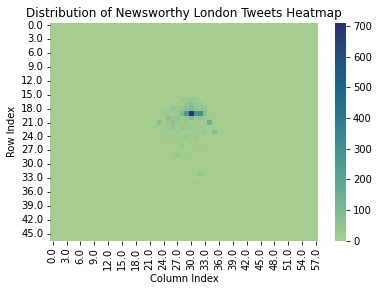

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(tweets_news_df_pivoted, cmap="crest")
plt.ylabel("Row Index")
plt.xlabel("Column Index")
plt.title("Distribution of Newsworthy London Tweets Heatmap")
plt.savefig('newslondontweetsheatmap.png', bbox_inches='tight')
plt.show()

We will also do the same for the non-newsworthy data. First we will set-up the data correctly.

In [ ]:
# create empty dataframe with columns row, col, and value
tweets_not_df = pd.DataFrame(columns=["Row", "Col", "Value"])

# iterate through grid_counts_news, filling dataframe
for tweet in grid_sizes_not:
  new_row = {"Row":int(tweet[0]), "Col":int(tweet[1]), "Value":int(grid_sizes_not[tweet])}
  tweets_not_df = tweets_not_df.append(new_row, ignore_index=True)

tweets_not_df = tweets_not_df.astype(float)
tweets_not_df_pivoted = tweets_not_df.pivot('Row', 'Col', 'Value')

And create the non-newsworthy heat map!

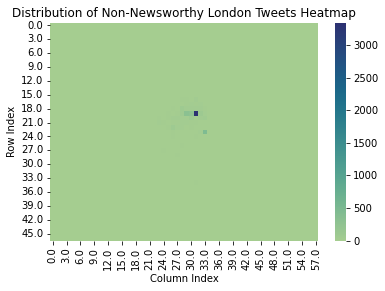

In [ ]:
sns.heatmap(tweets_not_df_pivoted, cmap="crest")
plt.ylabel("Row Index")
plt.xlabel("Column Index")
plt.title("Distribution of Non-Newsworthy London Tweets Heatmap")
plt.savefig('notnewslondontweetsheatmap.png', bbox_inches='tight')
plt.show()

As we can see from the heatmaps, the newsworthy data is a lot more spread out while the non-newsworthy data is more concentrated in the very center, much like the overall spread.

Let's also create the histogram to show the distribution of tweets per cell. First, we'll need to turn the grid totals into lists.

In [ ]:
grid_totals_news = tweets_news_df['Value'].tolist()
grid_totals_not = tweets_not_df['Value'].tolist()

Here is the plot for the newsworthy data.

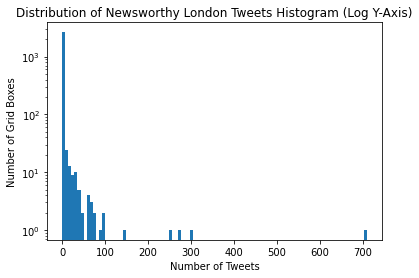

In [ ]:
plt.hist(grid_totals_news, bins=100, log=True)
plt.ylabel("Number of Grid Boxes")
plt.xlabel("Number of Tweets")
plt.title("Distribution of Newsworthy London Tweets Histogram (Log Y-Axis)")
plt.savefig('distnewslondontweetslog.png')
plt.show()

And for the non-newsworthy data.

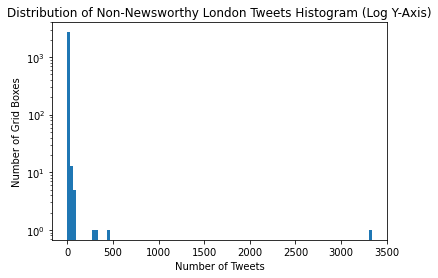

In [ ]:
plt.hist(grid_totals_not, bins=100, log=True)
plt.ylabel("Number of Grid Boxes")
plt.xlabel("Number of Tweets")
plt.title("Distribution of Non-Newsworthy London Tweets Histogram (Log Y-Axis)")
plt.savefig('distnotnewslondontweetslog.png')
plt.show()

As we can see, although there are still a lot of empty cells for both the newsworthy and non-newsworthy data, the newsworthy data is noticeably more spread out than the non-newsworthy data.

## Q4

One of the notable issues with this dataset is the number of tweets that are coming from outside sources. Let's create a counter of the sources for the entire dataset.

In [ ]:
# list to hold the sources for each of the tweets
sources = []
# iterate through the tweets, noting the source
for tweet in json_list:
  sources.append(tweet['source'])

source_counts = Counter(sources)
source_counts

Counter({'Instagram': 8019,
         'everybot': 309,
         'Untappd': 157,
         'Foursquare': 400,
         'CareerArc 2.0': 1083,
         'Foursquare Swarm': 176,
         'Hootsuite Inc.': 17,
         'dlvr.it': 251,
         'Squarespace': 47,
         'Landmark Manager Web': 2,
         'World Flags': 3,
         'FL': 6,
         'Wikishire': 8,
         'Leading Restaurants': 2,
         'Estate Agent Feeds': 3,
         'Tweetbot for iΟS': 5,
         '#Träwelling': 3,
         'BLUF.com': 2,
         'citydescriber': 2,
         'Hackney-a-la-mode': 5,
         'Good Stuff Tweeter': 1,
         'I Heart Locations': 4,
         "edent's Tweeting Robot": 3,
         'LuxuryRealEstate.com': 1,
         'TweetCaster for Android': 3,
         'trendsmetadata': 3,
         'Liveuamap': 1,
         'Brooklyn à la mode': 3,
         'narrowbotR': 1,
         'Twitter for iPhone': 1,
         'trainlogger': 4,
         'Fenix 2': 1})

As we can see here, nearly every single one of the tweets is from an outside source, other than one tweet coming from Twitter for iPhone. Even more notably, 76.2% of the tweets are from Instagram. 

Earlier, we noted that tweets from Instagram seem to give the same coordinates for location. Let's remember back to the tweets in the hottest grid box (19, 31). Let's look at the coordinate counts in that box.

In [ ]:
# list to hold the coordinates for tweets in (19, 31)
coords_1931 = []
# iterate through the tweet list, keeping track of the coords for tweets in the (19, 31) box
for tweet in json_list:
  if tweet['grid_box'] == [19, 31]:
    coords_1931.append(tuple(tweet['coordinates']))

print("Total tweets in (19, 31) box: " + str(len(coords_1931)))
print("Tweets at (-0.1094, 51.5141): " + str(Counter(coords_1931)[(-0.1094, 51.5141)]))

Total tweets in (19, 31) box: 3605
Tweets at (-0.1094, 51.5141): 3527


Nearly 98% of all tweets in the (19, 31) grid box are at the coordinates (-0.1094, 51.5141). Let's look at the sources of those tweets.

In [ ]:
# list to hold the sources for tweets in (19, 31)
sources_1931 = []
# iterate through the tweet list, keeping track of the sources for tweets with the specific coords in the (19, 31) box
for tweet in json_list:
  if tweet['grid_box'] == [19, 31] and tuple(tweet['coordinates']) == (-0.1094, 51.5141):
    sources_1931.append(tweet['source'])

Counter(sources_1931)

Counter({'Instagram': 3527})

Every single one of the tweets at those coordinates is from Instagram. Let's look at the second most popular box, (19, 30).

In [ ]:

coords_1930 = []
# iterate through the tweet list, keeping track of the coords for tweets in the (19, 30) box
for tweet in json_list:
  if tweet['grid_box'] == [19, 30]:
    coords_1930.append(tuple(tweet['coordinates']))

print("Total tweets in (19, 30) box: " + str(len(coords_1930)))
Counter(coords_1930).most_common(5)

Total tweets in (19, 30) box: 981


[((-0.1277583, 51.5073509), 546),
 ((-0.12731805, 51.50711486), 98),
 ((-0.12721, 51.50643), 39),
 ((-0.11714464, 51.51106761), 15),
 ((-0.1228, 51.51196944), 13)]

Here we see that for the (19, 30) box, the number of tweets at a single coordinate is not as extreme. There are still 56% of the tweets at (-0.1277583, 51.5073509). Let's look at the sources for those tweets.

In [ ]:
sources_1930 = []
# iterate through the tweet list, keeping track of the sources for the tweets with the specific coords in the (19, 30) box
for tweet in json_list:
  if tweet['grid_box'] == [19, 30] and tuple(tweet['coordinates']) == (-0.1277583, 51.5073509):
    sources_1930.append(tweet['source'])

Counter(sources_1930)

Counter({'CareerArc 2.0': 532, 'Squarespace': 11, 'Instagram': 3})

This time they are not all from Instagram, rather from CareerArc2.0, the second most popular source in the dataset. 



Both of these examples are evidence of why geolocalisation of this dataset is not entirely accurate. Although these tweets are populated with coordinates, all of the coordinates are coming from third party apps which the tweets are being posted from. When a tweet has the source 'Instagram', the coordinates for that tweet are whatever coordinates 'Instagram' gives. We don't know how precise those coordinates are. Similarly for CareerArc2.0.